In [1]:
import numpy as np
from scipy import stats

import numdifftools as nd

from pathlib import Path

from cobaya.theory import Theory
from cobaya.run import run
from cobaya.log import LoggedError

from getdist.mcsamples import MCSamplesFromCobaya
import getdist.plots as gdplt

In [4]:
PROJECT_DIR = Path.cwd()

OUT_PATH = PROJECT_DIR / 'output/'
OUT_PATH.mkdir(exist_ok=True, parents=True)

DATA_PATH = OUT_PATH / 'data/'
DATA_PATH.mkdir(exist_ok=True, parents=True)

In [2]:
rng = np.random.default_rng(1234)
pert_min = 1
pert_max = 2
pert_order = rng.integers(low=pert_min, high=pert_max, size=1)

coefs_truth = np.zeros(pert_max+1)
coefs_truth[0] = 0.75
coefs_truth[pert_order] = 0.1

poly_truth = np.polynomial.Polynomial(coefs_truth)
sample_std_dev = 0.05

n_samples = 100
sample_points = np.linspace(-1,1,num=n_samples)
samples_truth = poly_truth(sample_points)
sample_noise = rng.normal(0, sample_std_dev, n_samples)
sample_observed = samples_truth+sample_noise

[output] Output to be read-from/written-into folder '/home/mcmeiers/Projects/sandbox/modeling/output/data', with prefix 'baseline'
[noisy_data_like] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[prior] Reference values or pdfs for some parameters were not provided. Sampling from the prior instead for those parameters.
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {noisy_data_like: 3120.0}
[prior] *WARNING* Reference pdf not defined or improper for some parameters. Using prior's sigma instead for them.
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: q0:0.3815026
[mcmc] Sampling!
[mcmc] Progress @ 2022-03-06 16:17:41 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 40 samples accepted.
[mcmc]  - Acceptance rate: 0.040
[mcmc]  - Convergence of means: 

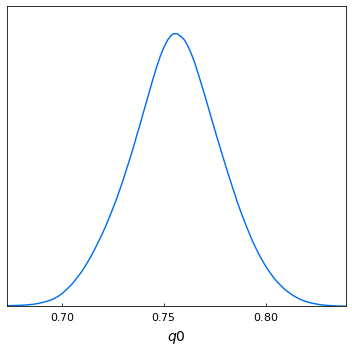

In [6]:
baseline_model_order  =  1
baseline_model_keys =  tuple('q'+str(i) for i in range(baseline_model_order))
baseline_model_ranges = dict((k,(-1,1)) for k in baseline_model_keys)

exec("def get_baseline_polynomial_vals(" + ",".join(baseline_model_keys) + "): return np.polynomial.Polynomial(["+",".join(baseline_model_keys)+"])(sample_points)")

exec("def baseline_noisy_data_logp(" + ",".join(baseline_model_keys) + "): return stats.multivariate_normal.logpdf(get_baseline_polynomial_vals(" + ",".join(baseline_model_keys) + "), mean=sample_observed, cov=sample_std_dev)")

baseline_likelihood_info = {'noisy_data_like': baseline_noisy_data_logp}
baseline_params_info = {k: {"prior": {"min": -1, "max": 1}} for k in baseline_model_keys}
baseline_sampler_info = {'mcmc':{'Rminus1_stop': 0.001, 'max_tries':1000}}
baseline_info = {'likelihood':baseline_likelihood_info,
        'params':baseline_params_info,
        'sampler':baseline_sampler_info,
        'output':DATA_PATH /  'baseline'}

baseline_updated_info, baseline_sampler = run(baseline_info)
baseline_gdsamples = MCSamplesFromCobaya(baseline_updated_info, baseline_sampler.products()["sample"])
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(baseline_gdsamples, baseline_model_keys, filled=True)

baseline_bestfit =  baseline_gdsamples.getParamSampleDict(np.argmin(baseline_gdsamples.loglikes))

In [5]:
extnd_model_order  =  pert_max+1
extnd_model_keys =  tuple('q'+str(i) for i in range(extnd_model_order))
extnd_model_ranges = dict((k,(-1,1)) for k in extnd_model_keys)

exec("def get_extnd_polynomial_vals(" + ",".join(extnd_model_keys) + "): return np.polynomial.Polynomial(["+",".join(extnd_model_keys)+"])(sample_points)")

exec("def extnd_noisy_data_logp(" + ",".join(extnd_model_keys) + "): return stats.multivariate_normal.logpdf(get_extnd_polynomial_vals(" + ",".join(extnd_model_keys) + "), mean=sample_observed, cov=sample_std_dev)")

[noisy_data_like] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[prior] Reference values or pdf's for some parameters were not provided. Sampling from the prior instead for those parameters.
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {noisy_data_like: 1390.0}
[prior] *WARNING* Reference pdf not defined or improper for some parameters. Using prior's sigma instead for them.
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: q0:0.03900167, q1:0.8779435, q2:0.8029214
[mcmc] Sampling!
[mcmc] Progress @ 2022-03-05 16:50:22 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 120 samples accepted.
[mcmc]  - Acceptance rate: 0.014
[mcmc]  - Convergence of means: R-1 = 0.438809 after 120 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] 

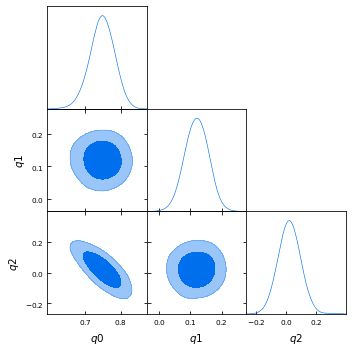

In [6]:

extnd_likelihood_info = {'noisy_data_like': extnd_noisy_data_logp}
extnd_params_info = {k: {"prior": {"min": -1, "max": 1}} for k in extnd_model_keys}
extnd_sampler_info = {'mcmc':{'Rminus1_stop': 0.001, 'max_tries':1000}}
extnd_info = {'likelihood': extnd_likelihood_info,
        'params': extnd_params_info,
        'sampler': extnd_sampler_info}

extnd_updated_info, extnd_sampler = run(extnd_info)
extnd_gdsamples = MCSamplesFromCobaya(extnd_updated_info, extnd_sampler.products()["sample"])
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(extnd_gdsamples, extnd_model_keys, filled=True)

In [2]:
np.polynomial.Polynomial([1,2])

Polynomial([1., 2.], domain=[-1,  1], window=[-1,  1])

In [54]:
extnd_gdsamples.mean(extnd_model_keys)

array([0.74892646, 0.11732928, 0.02194141])

In [53]:
extnd_gdsamples.std(extnd_model_keys)

array([0.03356573, 0.03832737, 0.0737004 ])

In [12]:
test=baseline_gdsamples.likeStats.bestfit

AttributeError: 'LikeStats' object has no attribute 'bestfit'

Best fit sample -log(Like) = -49.466009
Ln(mean 1/like) = -48.048324
mean(-Ln(like)) = -48.972227
-Ln(mean like)  = -49.132091

parameter               bestfit        lower1         upper1         lower2         upper2
q0                      7.5635864E-01  7.3491587E-01  7.7775076E-01  7.1098939E-01  8.0177907E-01   q0
chi2*                  -1.0031831E+02 -1.0031831E+02 -9.9398155E+01 -1.0031831E+02 -9.6193495E+01   \chi^2
chi2__noisy_data_like* -1.0031831E+02 -1.0031831E+02 -9.9398155E+01 -1.0031831E+02 -9.6193495E+01   \chi^2_\mathrm{noisy\ data\ like}



In [32]:
baseline_gdsamples.getParamBestFitDict(max_posterior=False)

KeyboardInterrupt: 

In [30]:
baseline_sampler.products()['sample']

      weight  minuslogpost        q0  minuslogprior  minuslogprior__0  \
0       23.0    -49.183620  0.773170       0.693147          0.693147   
1       28.0    -49.409011  0.748816       0.693147          0.693147   
2       20.0    -47.328852  0.802595       0.693147          0.693147   
3       43.0    -49.336591  0.744989       0.693147          0.693147   
4       52.0    -49.442528  0.761211       0.693147          0.693147   
...      ...           ...       ...            ...               ...   
2475     1.0    -48.993829  0.734636       0.693147          0.693147   
2476     7.0    -48.894822  0.732466       0.693147          0.693147   
2477     2.0    -49.463111  0.758068       0.693147          0.693147   
2478     1.0    -49.427107  0.762602       0.693147          0.693147   
2479     7.0    -48.834893  0.781487       0.693147          0.693147   

            chi2  chi2__noisy_data_like  
0     -99.753534             -99.753534  
1    -100.204316            -100.204316

In [33]:
baseline_gdsamples.getParamBestFitDict(max_posterior=False)

TypeError: unsupported operand type(s) for +: 'NoneType' and 'str'

In [34]:
baseline_gdsamples.getParamSampleDict(np.argmin(baseline_gdsamples.loglikes))

{'weight': 3.0,
 'loglike': -49.466008910381426,
 'q0': 0.7563586448274913,
 'chi2': -100.31831218188275,
 'chi2__noisy_data_like': -100.31831218188275,
 'minuslogprior': 0.6931471805599453,
 'minuslogprior__0': 0.6931471805599453}

In [35]:
np.argmin(baseline_gdsamples.loglikes)

2095

In [49]:
Hess = nd.Derivative(baseline_noisy_data_logp,n=2)

In [55]:
Hess(baseline_gdsamples.getParamSampleDict(np.argmin(baseline_gdsamples.loglikes))['q0'])

array(-2000.)

In [42]:
np.array([baseline_gdsamples.getParamSampleDict(np.argmin(baseline_gdsamples.loglikes))[k] for k in baseline_model_keys])

array([0.75635864])

In [46]:
np.array([baseline_gdsamples.getParamSampleDict(np.argmin(baseline_gdsamples.loglikes))[k] for k in baseline_model_keys])

array([0.75635864])

In [51]:
baseline_noisy_data_logp(0.4)

-76.83708461031425

In [34]:
def extnd_noisy_data_logp_of_vec(coefs):
        return extnd_noisy_data_logp(*coefs)

extnd_hess = nd.Hessian(extnd_noisy_data_logp_of_vec)


In [35]:
extnd_hess(np.array([extnd_gdsamples.getParamSampleDict(np.argmin(extnd_gdsamples.loglikes))[k] for k in extnd_model_keys]))

array([[-2.00000000e+03, -2.72735549e-15, -6.80134680e+02],
       [-2.72735549e-15, -6.80134680e+02,  0.00000000e+00],
       [-6.80134680e+02,  0.00000000e+00, -4.16269349e+02]])

In [59]:
np.array([extnd_gdsamples.getParamSampleDict(np.argmin(extnd_gdsamples.loglikes))[k] for k in extnd_model_keys])

array([0.74838972, 0.11809471, 0.02112838])

In [67]:
extnd_noisy_data_logp(*np.array([0,0,0]))

-521.929339989716

In [69]:
extnd_noisy_data_logp_of_vec(np.array([0,0,0]))

In [12]:
extnd_model_order  =  pert_max+1
extnd_model_keys =  tuple('q'+str(i) for i in range(extnd_model_order))
extnd_model_csv_keys = ','.join(extnd_model_keys)
extnd_model_ranges = dict((k,(-1,1)) for k in extnd_model_keys)

def get_extnd_polynomial_vals(coefs):
        return np.polynomial.Polynomial(coefs)(sample_points)

def extnd_noisy_data_logp(coefs):
        return stats.multivariate_normal.logpdf(get_extnd_polynomial_vals(coefs), mean=sample_observed, cov=sample_std_dev)

In [ ]:

extnd_likelihood_info = {'noisy_data_like': extnd_noisy_data_logp}
extnd_params_info = {k: {"prior": {"min": -1, "max": 1},"drop":True} for k in extnd_model_keys}
extnd_params_info['coefs'] = {'value':"lambda "+','.join(extnd_model_keys)+": ["+','.join(extnd_model_keys)+"]",
                              'derived':False}
extnd_sampler_info = {'mcmc':{'Rminus1_stop': 0.001, 'max_tries':1000}}
extnd_info = {'likelihood': extnd_likelihood_info,
        'params': extnd_params_info,
        'sampler': extnd_sampler_info}

extnd_updated_info, extnd_sampler = run(extnd_info)
extnd_gdsamples = MCSamplesFromCobaya(extnd_updated_info, extnd_sampler.products()["sample"])
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(extnd_gdsamples, extnd_model_keys, filled=True)

In [39]:
f'{extnd_model_csv_keys}'

TypeError: get_extnd_polynomial_vals() missing 2 required positional arguments: 'q1' and 'q2'

In [26]:
np.array(np.array([0,0,0]))

array([0, 0, 0])

In [36]:
get_extnd_polynomial_vals

<function __main__.get_extnd_polynomial_vals(q0, q1, q2)>

In [37]:
def get_extnd_polynomial_vals2(coefs):
        return np.polynomial.Polynomial(coefs)(sample_points)

In [38]:
get_extnd_polynomial_vals2

<function __main__.get_extnd_polynomial_vals2(coefs)>

In [44]:
nd.Gradient(extnd_noisy_data_logp)(np.array([0,0,0]))

array([1512.73063845,   79.95744617,  518.29747407])

In [10]:
extnd_baeline_bestfit = [baseline_bestfit.get(k,0) for k in extnd_model_keys]

In [11]:
extnd_baeline_bestfit

[0.7563653917028231, 0, 0]

In [11]:
baseline_params_info = {k: {"prior": {"min": -1, "max": 1}} for k in baseline_model_keys}
baseline_sampler_info = {'mcmc':{'Rminus1_stop': 0.0001, 'max_tries':1000}}
baseline_info = {'likelihood':baseline_likelihood_info,
        'params':baseline_params_info,
        'sampler':baseline_sampler_info,
        'output':DATA_PATH /  'baseline'}

baseline_updated_info, baseline_sampler = run(baseline_info,resume=True,)

[output] Output to be read-from/written-into folder '/home/mcmeiers/Projects/sandbox/modeling/output/data', with prefix 'baseline'
[output] Found existing info files with the requested output prefix: '/home/mcmeiers/Projects/sandbox/modeling/output/data/baseline'
[output] Let's try to resume/load.
[output] Found an old sample. Resuming.
[noisy_data_like] Initialized external likelihood.
[mcmc] Resuming from previous sample!
[samplecollection] Loaded 3320 sample points from '/home/mcmeiers/Projects/sandbox/modeling/output/data/baseline.1.txt'
[mcmc] Covariance matrix from previous sample.
[mcmc] Initial point: q0:0.7362843
[mcmc] Sampling!
[mcmc] Progress @ 2022-03-06 16:44:31 : 1 steps taken, and 3320 accepted.
[mcmc] Learn + convergence test @ 3360 samples accepted.
[mcmc]  - Acceptance rate: 0.431
[mcmc]  - Convergence of means: R-1 = 0.000537 after 2688 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 3400 samples accepted.
[mcmc]